### Summary 

In this notebook, we will use the Titanic dataset. This data consists of demographic and traveling information for 891 of the Titanic's passengers.
The goal is to predict which of these passengers survived.

To predict this, we will follow four steps: 
1. First, we will clean up the data, for example by replacing missing values and by scaling the features 
2. Secondly, we will perform gradient descent to learn how probable it is that different people on the Titanic survived (e.g. based on age, gender, etc.)
3. Thirdly, we will determine the accuracy of these predictions, e.g. by making a confusion matrix. 
4. Fourthly, we will analyze the patterns in the data and visualize these patterns. 

To start with the conclusions: 
- More people died than survived, and women have a much higher survival rate than men.
Possibly due to the fact that they were put into life boats first. 
- People who resided in the third class had a very low survival rate, possibly due to the position of the third-class cabins on the Titanic. 
- Younger people have a higher survival probability than older people.  

Before we dive into the dataset, first I'll give a brief overview of how the dataset looks like. 

Here is a summary of the data set's attributes:

- *PassengerId*: passenger ID assigned in this dataset
- *Survived*: a Boolean indicating whether the passenger survived or not (0 = No; 1 = Yes); this is our target
- *Pclass*: passenger class (1 = 1st; 2 = 2nd; 3 = 3rd)
- *Name*: field containing the name and title of the passenger
- *Sex*: male/female
- *Age*: age of the passenger in years
- *SibSp*: number of siblings/spouses aboard
- *Parch*: number of parents/children aboard
- *Ticket*: ticket number
- *Fare*: passenger fare in British Pounds
- *Cabin*: location of the cabin, consisting of a letter indicating the deck, and a cabin number.
- *Embarked*: port of embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)

In [3]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('titanic.csv')

display(data.head())
data.info()
display(data.describe())

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


There are several things we can already conclude: 

- *PassengerId* is a column that runs from 1 to 891, indicating the index of a passenger in this dataset. This variable has no descriptive value for the passenger, but it could still cause our machine learning model to find some correlations that are really just noise, so we should delete this whole column before using the data for training.
- The mean of *Survived* indicates that out of the 891 people in our dataset, only ~38% of people survived. This can be deduced from the mean of the column, because the value 1 corresponds to survived and 0 corresponds to did not survive. As an example, when 90% of these values would be 1, we would end up with a mean of 0.9, as the other values are all zeros.
- There are more people in *Passenger Class* 3 than in class 1 and 2 combined. This can be concluded from the fact that from the 50th percentile to the maximum value, every passenger is in third class.
- There is at least one baby in our dataset, with an *Age* of 0.42, or 5 months. The oldest person is 80 years old. We can see this from the min and max values of the *Age* column.
- There are 277 people of which we do not know the *Age*. We have 891 data entries, but the `count` for age is 714, so 891 - 714 = 277.
- The majority of people has no *Siblings/Spouses* aboard. This can be concluded from the percentiles.
- The majority of people has no *Parents/Children* aboard. This can be concluded from the percentiles.
- There is a big difference in scale in data. Fare can be up to 512 pounds while the number of *Parents/Children* on board is only up to 6.  We can also see this in the standard deviations, where the difference is also very large. 

In [4]:
# We'll remove features from the data that we won't use 
clean_data = data.drop(['PassengerId', 'Name', 'Ticket'], axis=1)

clean_data.info()

# Since the cabin feature has many missing values, we will drop them for now 
clean_data = clean_data.drop(['Cabin'], axis=1)

clean_data.info()

# Since there are only two missing values for 'Embarked', we'll drop these 
clean_data = clean_data.dropna(subset=['Embarked'])

clean_data.info()

# We'll replace missing age values by the mean age 
mean = clean_data['Age'].mean()
clean_data['Age'] = clean_data['Age'].fillna(mean)

clean_data.info()
display(clean_data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Cabin     204 non-null    object 
 8   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(3)
memory usage: 62.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null

,Survived,Pclass,Age,SibSp,Parch,Fare
count,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000
mean,0.382452,2.311586,29.642093,0.524184,0.382452,32.096681
std,0.486260,0.834700,12.968346,1.103705,0.806761,49.697504
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,22.000000,0.000000,0.000000,7.895800
50%,0.000000,3.000000,29.642093,0.000000,0.000000,14.454200
75%,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


We will also need to transform the categorical data ('Sex' and 'Embarked') into numerical data that our logistical model can work with. We will transform our categorical data using one-hot encodings. 

In [5]:
# Create two new columns for the male and female one-hot encoding
sex = pd.get_dummies(clean_data['Sex'], dtype=int)

# Create three new columns for port of embarkment one-hot encoding
embark = pd.get_dummies(clean_data['Embarked'], dtype=int)

# We no longer need these columns, as we will replace them soon
clean_data = clean_data.drop(['Sex','Embarked'], axis=1)

# Create the new dataframe with the one-hot columns we created from the categories in Sex and Embarked
clean_data = pd.concat([clean_data, sex, embark], axis=1)

clean_data.info()
display(clean_data.head())

<class 'pandas.core.frame.DataFrame'>
Index: 889 entries, 0 to 890
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  889 non-null    int64  
 1   Pclass    889 non-null    int64  
 2   Age       889 non-null    float64
 3   SibSp     889 non-null    int64  
 4   Parch     889 non-null    int64  
 5   Fare      889 non-null    float64
 6   female    889 non-null    int32  
 7   male      889 non-null    int32  
 8   C         889 non-null    int32  
 9   Q         889 non-null    int32  
 10  S         889 non-null    int32  
dtypes: float64(2), int32(5), int64(4)
memory usage: 66.0 KB


,Survived,Pclass,Age,SibSp,Parch,Fare,female,male,C,Q,S
0,0,3,22.0,1,0,7.2500,0,1,0,0,1
1,1,1,38.0,1,0,71.2833,1,0,1,0,0
2,1,3,26.0,0,0,7.9250,1,0,0,0,1
3,1,1,35.0,1,0,53.1000,1,0,0,0,1
4,0,3,35.0,0,0,8.0500,0,1,0,0,1


Now we will normalize the data to prevent any feature dominating the rest.
Also, we'll split the data into training and testing data, so that we can determine the accuracy of our model later. 

In [6]:
from scipy.stats import zscore

numerical = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
clean_data[numerical] = clean_data[numerical].apply(zscore)

display(clean_data.describe())

,Survived,Pclass,Age,SibSp,Parch,Fare,female,male,C,Q,S
count,889.000000,8.890000e+02,8.890000e+02,8.890000e+02,8.890000e+02,8.890000e+02,889.000000,889.000000,889.000000,889.000000,889.000000
mean,0.382452,-2.437745e-16,-2.957264e-16,-3.197043e-17,-4.795564e-17,1.398706e-16,0.350956,0.649044,0.188976,0.086614,0.724409
std,0.486260,1.000563e+00,1.000563e+00,1.000563e+00,1.000563e+00,1.000563e+00,0.477538,0.477538,0.391710,0.281427,0.447063
min,0.000000,-1.572211e+00,-2.254608e+00,-4.751991e-01,-4.743259e-01,-6.462044e-01,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,-3.735013e-01,-5.896199e-01,-4.751991e-01,-4.743259e-01,-4.872378e-01,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,8.252086e-01,-5.482138e-16,-4.751991e-01,-4.743259e-01,-3.551972e-01,0.000000,1.000000,0.000000,0.000000,1.000000
75%,1.000000,8.252086e-01,4.133853e-01,4.313502e-01,-4.743259e-01,-2.207954e-02,1.000000,1.000000,0.000000,0.000000,1.000000
max,1.000000,8.252086e-01,3.885326e+00,6.777195e+00,6.967010e+00,9.668551e+00,1.000000,1.000000,1.000000,1.000000,1.000000


In [7]:
from sklearn.model_selection import train_test_split

# Split the data into target "y" and input "X"
y_df = clean_data['Survived']
X_df = clean_data.drop('Survived', axis=1)

# Convert the Pandas DataFrames to Numpy ndarrays
X_np = X_df.to_numpy()
y_np = np.expand_dims(y_df.to_numpy(), axis=1)

#Split the data into 70% training and 30% testing
X_train, X_test, y_train, y_test = train_test_split(X_np, y_np, train_size=0.7, random_state=1265599650)

In [8]:
def logistic_func(z):
    return 1 / (1 + np.exp(-z))

z_values = np.linspace(-5, 5, 100)
g_values = logistic_func(z_values)

def logistic_model(X, w, b):
    """
    Compute the logistic regression hypothesis for input matrix X.

    Parameters:
    - X: input features, shape (n_samples, n_features)
    - w: weights vector, shape (n_features,)
    - b: scalar bias

    Returns:
    - probabilities: shape (n_samples,)
    """
    z_scores = np.matmul(X, w) + b 
    return logistic_func(z_scores)


In [9]:
def logistic_cost(w, b, X, y):
    """
    Compute the binary cross-entropy cost for logistic regression.

    Parameters:
    - w (ndarray): Weight vector of shape (n_features,)
    - b (float): Scalar bias term
    - X (ndarray): Input feature matrix of shape (m_samples, n_features)
    - y (ndarray): True labels of shape (m_samples,), with values 0 or 1

    Returns:
    - cost (float): Average binary cross-entropy loss over all samples
    """
    # Step 1: Compute predicted probabilities using logistic model
    y_hat = logistic_model(X, w, b)

    # Step 2: Prevent numerical issues by avoiding log(0)
    y_hat = np.clip(y_hat, 1e-15, 1 - 1e-15)

    # Step 3: Compute binary cross-entropy loss for each sample
    loss_per_sample = y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat)

    # Step 4: Take mean over all samples and flip the sign to return positive cost
    return -np.mean(loss_per_sample)


In [10]:
def b_gradient(w, b, X, y):
    """
    Compute the gradient of the logistic cost function with respect to the bias term b.

    Parameters:
    -----------
    w : numpy.ndarray
        The weight vector.
    b : float
        The bias term.
    X : numpy.ndarray
        The input feature matrix.
    y : numpy.ndarray
        The vector of true labels.

    Returns:
    --------
    float
        The average gradient of the cost function with respect to b.
    """
    m = y.shape[0]
    # Use logistic_model to compute predictions
    total_error = np.sum(logistic_model(X, w, b) - y)
    return total_error / m

def w_gradient(w, b, X, y):
    """
    Compute the gradient of the logistic cost function with respect to the weight vector w.

    Parameters:
    -----------
    w : numpy.ndarray
        The weight vector.
    b : float
        The bias term.
    X : numpy.ndarray
        The input feature matrix.
    y : numpy.ndarray
        The vector of true labels.

    Returns:
    --------
    numpy.ndarray
        The gradient of the cost function with respect to w.
    """
    m = y.shape[0]
    # Use logistic_model to compute predictions for logistic regression
    y_hat = logistic_model(X, w, b)
    errors = y_hat - y  # error vector
    # Compute gradient: dot product of features and error vector, scaled by m
    grad = np.matmul(X.T, errors) / m
    return grad

def gradient_descent(X, y, w, b, alpha, thres=1e-6):
    """
    Perform gradient descent to optimize the logistic regression cost function.

    This function updates the weight vector w and bias b iteratively using
    their respective gradients until the change in cost is below the specified threshold
    or divergence is detected.

    Parameters:
    -----------
    X : numpy.ndarray
        The input feature matrix.
    y : numpy.ndarray
        The vector of true labels.
    w : numpy.ndarray
        The initial weight vector.
    b : float
        The initial bias term.
    alpha : float
        The learning rate.
    thres : float, optional
        The convergence threshold for the change in cost (default is 1e-6).

    Returns:
    --------
    tuple
        A tuple (w, b) containing the optimized weight vector and bias term.
    """
    cost_delta = logistic_cost(w, b, X, y)
    
    while cost_delta > thres and cost_delta > 0:
        cost_prior = logistic_cost(w, b, X, y)
        
        # Compute gradients concurrently
        grad_w = w_gradient(w, b, X, y)
        grad_b = b_gradient(w, b, X, y)
        
        # Update parameters simultaneously
        w = w - alpha * grad_w
        b = b - alpha * grad_b
        
        cost_posterior = logistic_cost(w, b, X, y)
        cost_delta = cost_prior - cost_posterior
        
        if cost_delta < 0:
            print(f"Cost increased by {cost_delta}; stopping to avoid divergence.")
            break
            
    return w, b

# Initialize parameters
w = np.zeros((X_train.shape[1], 1))
b = 0

# Run gradient descent
w_hat, b_hat = gradient_descent(X_train, y_train, w, b, alpha=1e-4)

print('w:', w_hat)
print('b:', b_hat)


w: [[-0.42245195]
 [-0.16952217]
 [-0.11465412]
 [ 0.08995297]
 [ 0.24693307]
 [ 0.47087209]
 [-0.64376821]
 [ 0.05535226]
 [ 0.00347353]
 [-0.2317219 ]]
b: -0.17289611464030671


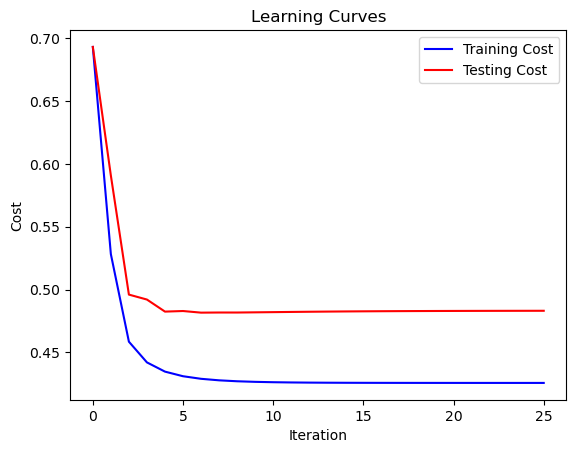

w: [[-0.89737086]
 [-0.4373851 ]
 [-0.3447049 ]
 [ 0.00309952]
 [ 0.11587362]
 [ 1.39885703]
 [-1.47145103]
 [ 0.14776898]
 [ 0.10790264]
 [-0.32826563]]
b: -0.07259400746703201


In [11]:
def gradient_descent_learning_curves(X_train, y_train, X_test, y_test, w, b, alpha, thres=1e-6):
    """
    Perform gradient descent for logistic regression while tracking and plotting the learning curves.

    This function implements gradient descent to minimize the logistic cost function on the training data,
    while also storing the training and testing cost at every iteration. After convergence (or divergence),
    it plots the learning curves (training and testing cost vs. iteration) and returns the final parameters.

    Parameters:
    -----------
    X_train : numpy.ndarray
        Training feature matrix.
    y_train : numpy.ndarray
        Training labels.
    X_test : numpy.ndarray
        Testing feature matrix.
    y_test : numpy.ndarray
        Testing labels.
    w : numpy.ndarray
        Initial weight vector.
    b : float
        Initial bias.
    alpha : float
        Learning rate.
    thres : float, optional
        Convergence threshold for the change in cost (default is 1e-6).

    Returns:
    --------
    tuple
        A tuple (w, b) containing the optimized weight vector and bias.
    """
    cost_delta = logistic_cost(w, b, X_train, y_train)
    
    # Initialize lists to store training and testing costs at each iteration
    training_costs = []
    test_costs = []
    
    # Run gradient descent until the change in cost is below the threshold or divergence is detected
    while cost_delta > thres and cost_delta > 0:
        cost_prior = logistic_cost(w, b, X_train, y_train)
        
        # Store current training and testing costs
        training_costs.append(cost_prior)
        test_costs.append(logistic_cost(w, b, X_test, y_test))
        
        # Compute gradients concurrently
        grad_w = w_gradient(w, b, X_train, y_train)
        grad_b = b_gradient(w, b, X_train, y_train)
        
        # Update parameters simultaneously
        w = w - alpha * grad_w
        b = b - alpha * grad_b
        
        cost_posterior = logistic_cost(w, b, X_train, y_train)
        cost_delta = cost_prior - cost_posterior
        
        if cost_delta < 0:
            print(f"Cost increased by {cost_delta}; stopping to avoid divergence.")
            break
    
    # After gradient descent, compute the iteration numbers based on the cost lists
    number_of_iterations = list(range(len(training_costs)))
    
    # Plot the learning curves for training and testing costs
    plt.plot(number_of_iterations, training_costs, color='blue', label='Training Cost')
    plt.plot(number_of_iterations, test_costs, color='red', label='Testing Cost')
    plt.xlabel("Iteration")
    plt.ylabel("Cost")
    plt.title("Learning Curves")
    plt.legend()
    plt.show() 
    
    return w, b

# Example initialization and function call:
w = np.zeros((X_train.shape[1], 1))
b = 0

w_hat, b_hat = gradient_descent_learning_curves(X_train, y_train, X_test, y_test, w, b, alpha=4)

print('w:', w_hat)
print('b:', b_hat)


In [12]:
def predict(X, w, b):
    """
    Predict binary outcomes using a logistic regression model.

    This function computes predicted probabilities for each sample using the logistic_model,
    then converts these probabilities into binary predictions (0 or 1) using a decision boundary
    of 0.5. It uses boolean masking to update the probabilities in place:
    - Values >= 0.5 are set to 1.
    - Values < 0.5 are set to 0.

    Parameters:
    -----------
    X : numpy.ndarray
        The input feature matrix, where each row corresponds to a sample.
    w : numpy.ndarray
        The weight vector for the logistic regression model.
    b : float
        The bias term for the logistic regression model.

    Returns:
    --------
    numpy.ndarray
        An array of predictions (0 or 1) for each sample in X.
    """
    probabilities = logistic_model(X, w, b)
    mask = probabilities >= 0.5
    probabilities[mask] = 1  
    probabilities[~mask] = 0

    return probabilities

# Example usage:
predictions_train = predict(X_train, w_hat, b_hat)
predictions_test = predict(X_test, w_hat, b_hat)
print(predictions_train)


[[1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.

In [13]:
def calc_accuracy(predictions, y):
    """
    Calculate the accuracy based on the condition that a prediction is correct
    if the sum of prediction and true label is 0 (both 0) or 2 (both 1).
    
    Parameters:
    -----------
    predictions : numpy.ndarray
        Vector of predicted labels (0 or 1).
    y : numpy.ndarray
        Vector of true labels (0 or 1).
    
    Returns:
    --------
    float
        Accuracy as a ratio between 0 and 1.
    """
    total = predictions + y
    mask = (total == 0) | (total == 2)
    correct = np.sum(mask)
    return correct / predictions.shape[0]

    

print(f"Training set accuracy: {calc_accuracy(predictions_train, y_train)}")
print(f"Testing set accuracy: {calc_accuracy(predictions_test, y_test)}")

Training set accuracy: 0.8070739549839229
Testing set accuracy: 0.7790262172284644


In [18]:
def confusion_matrix(predictions, y):
    """
    Compute the 2×2 confusion matrix for binary classification.

    Parameters:
    -----------
    predictions : numpy.ndarray
        Vector of predicted labels (0 or 1).
    y : numpy.ndarray
        Vector of true labels (0 or 1).

    Returns:
    --------
    numpy.ndarray
        A 2×2 confusion matrix in the format:
        [[TP, FP],
         [FN, TN]]
    """
    stacked = np.stack((predictions, y), axis=1)
    
    # Unpack columns: pred = stacked[:, 0], truth = stacked[:, 1]
    TP = np.sum((stacked[:, 0] == 1) & (stacked[:, 1] == 1))  # predicted 1, actual 1
    FP = np.sum((stacked[:, 0] == 1) & (stacked[:, 1] == 0))  # predicted 1, actual 0
    FN = np.sum((stacked[:, 0] == 0) & (stacked[:, 1] == 1))  # predicted 0, actual 1
    TN = np.sum((stacked[:, 0] == 0) & (stacked[:, 1] == 0))  # predicted 0, actual 0
    
    return np.array([[TN, FP],
                     [FN, TP]])


print(confusion_matrix(predictions_test, y_test))

[[138  23]
 [ 36  70]]


### Compare to sklearn
We just implemented our own version of logistic regression. 
We can compare our results to using the Sklearn predefined logistic model. 

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

# 1. Train sklearn LogisticRegression 
clf = LogisticRegression(max_iter=1000)  
clf.fit(X_train, y_train.ravel())  

# 2. Make predictions
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

# 3. Calculate accuracy
print("Sklearn LogisticRegression:")
print(" - Training accuracy:", accuracy_score(y_train, y_pred_train))
print(" - Testing accuracy:", accuracy_score(y_test, y_pred_test))

# 4. Confusion matrix for testset
print("Confusion matrix (test):")
print(confusion_matrix(y_test, y_pred_test))


Sklearn LogisticRegression:
 - Training accuracy: 0.8070739549839229
 - Testing accuracy: 0.7790262172284644
Confusion matrix (test):
[[138  23]
 [ 36  70]]


As we see, the confusion matrix of our own model is identical to that of sklearn. 

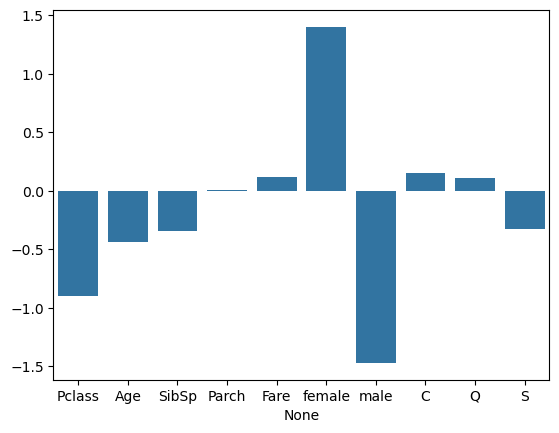

In [20]:
sns.barplot(x=X_df.columns, y=np.squeeze(w_hat))
plt.show()

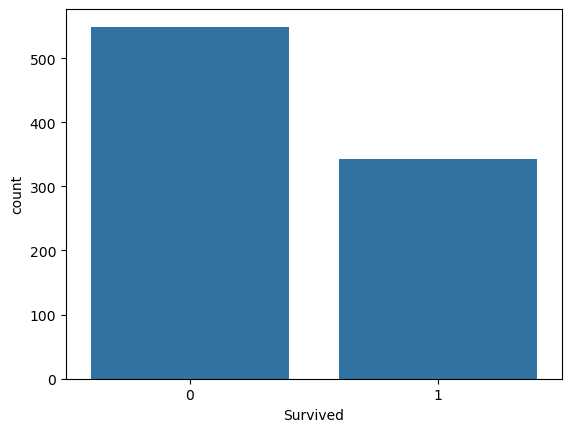

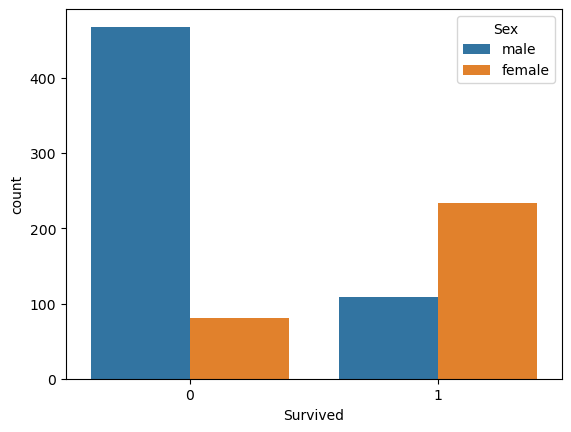

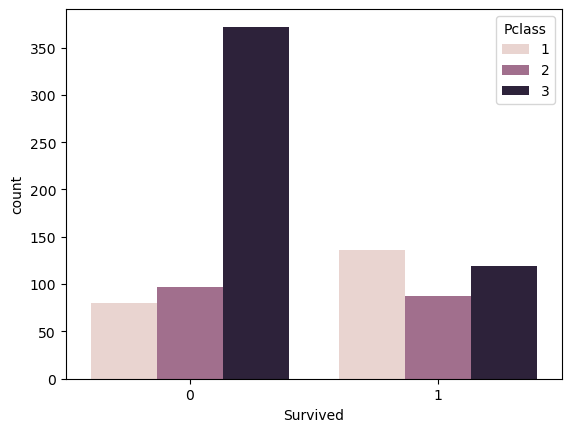

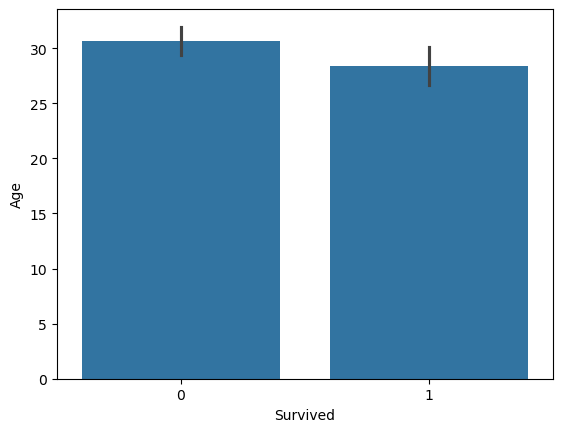

In [21]:
sns.countplot(x='Survived',data=data)
plt.show()

sns.countplot(x='Survived',hue='Sex',data=data)
plt.show()

sns.countplot(x='Survived',hue='Pclass',data=data)
plt.show()

sns.barplot(x='Survived', y='Age', data=data)
plt.show()

## Creating hypotheses for the data

For each of the 3 features plotted above, we compare their individual impact on the survival chance of a passenger. For every feature, we explain this feature has a positive or negative effect on the survival chance of a passenger. And we provide an hypothesis on why this feature is likely to affect survival. 

**Q1. Gender of the passenger**

Logistic Regression Finding:

- “male” has a strongly negative weight.

- “female” has a strongly positive weight.
Interpreted together, the model suggests being female substantially increases the predicted probability of survival compared to being male.

Possible Reasons:

- Evacuation Priorities: Historically (and famously in the Titanic’s case), the phrase “women and children first” often guided rescue protocols.

- Physical/Behavioral Factors: Women may have been helped first by other passengers or crew.

- Social Norms: Cultural expectations of the era could have led to women being escorted to lifeboats more readily.

Connecting to the Weight:

- A positive weight for “female” means that, after standardizing, higher values in this feature (i.e., being female = 1) push the log-odds of survival up.

- A negative weight for “male” means that, for passengers identified as male, the predicted probability of survival goes down.

**Q2. Class of the passenger's cabin**

The analysis shows that third-class passengers had markedly lower survival rates. The corresponding weight for third-class status is strongly negative.
    
Hypothesis: This might be because third-class cabins were located further from the exits or lifeboats, or passengers in this class might have faced more barriers during evacuation (such as less guidance or physical obstacles).

Because passenger class is ordinal, a single negative weight for Pclass indicates that each “step” upward in class number (from 1 to 2, 2 to 3) lowers the predicted survival probability.

**Q3. Age of the passenger**

A negative weight for “Age” means older passengers have lower predicted survival probability. In the Titanic dataset, the evidence points to younger passengers faring better.

Possible Reasons:

- Physical Agility: Younger individuals may have been better able to move quickly through crowded corridors or climb obstacles to reach safety.
- Evacuation Priorities: Children were sometimes given priority in lifeboats, tying back to “women and children first.”
- Health and Stamina: Younger passengers might withstand cold temperatures and the stress of evacuation better than older passengers.

Connecting to the Weight:

- After z-score scaling, if “Age” is above the mean, the model’s negative weight lowers the survival probability.
- Being younger than average effectively “raises” your predicted survival probability.